<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/fourier_slice_1D_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* implement Fourier slice theorem in 2D to 1D case
* investigate how to implement interpolation

# Resources

- See Chapters 11 & 12 in `Hobbie, R. K., & Roth, B. J. (2007). Intermediate Physics for Medicine and Biology (4th ed.). New York, NY: Springer New York. http://doi.org/10.1007/978-0-387-49885-0`
- http://fab.cba.mit.edu/classes/862.19/people/erik/project.html
- See Fred Sigworth's animations in [CryoEM 2 4 Fourier 2D 3D](https://youtu.be/J1ViNmmQnd0?t=2001)

#Set up

In [ ]:
import numpy as np
import pandas as pd
from scipy import ndimage
import scipy.ndimage.interpolation
import matplotlib.pyplot as plt
def doplt(arr2d,cmap='gray',**kwargs):
  plt.imshow(arr2d,cmap=cmap,**kwargs)
def logabs(arr):
  return(np.log(1+np.abs(arr)))

In [ ]:
!pip install mrcfile

     |████████████████████████████████| 51kB 2.8MB/s 


In [ ]:
import mrcfile

In [ ]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/8dd2b07fedaafbebe8584e47315d2ffb2c0ff4e5/code/fourier.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/8dd2b07fedaafbebe8584e47315d2ffb2c0ff4e5/code/twod.py
!wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
!pip install pyfftw
import fourier, twod

# Data

In [ ]:
%%bash
wget ftp://ftp.wwpdb.org/pub/emdb/structures/EMD-7978/map/emd_7978.map.gz
gunzip emd_7978.map.gz

In [33]:
f = mrcfile.open('emd_7978.map')
map = f.data
f.close()
N = map.shape[0]

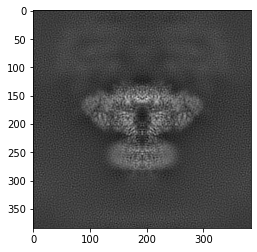

In [34]:
template_2d = map.sum(1)
doplt(template_2d)

## square

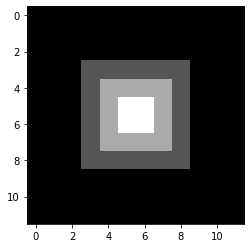

In [ ]:
N=12
sq = np.zeros((N, N))
sq[N//4:-N//4, N//4:-N//4] = 1
sq = ndimage.distance_transform_bf(sq)
doplt(sq)

In [ ]:
template_2d = sq

## 2D gaussian

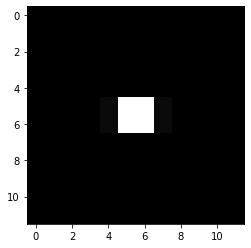

In [ ]:
x, y = np.meshgrid(np.linspace(-1,1,N), np.linspace(-1,1,N))
d = np.sqrt(x*x+3*y*y)
sigma, mu = .1, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
doplt(g)

In [ ]:
template_2d = g


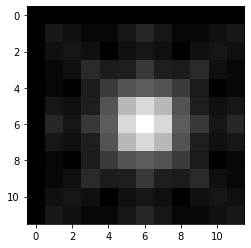

In [ ]:
template_2d_f = twod.do_fft(template_2d, only_real=False)
doplt(np.log(1+np.abs(template_2d_f)))

# Fourier slice theorem (1D/2D)
The Fourier transform of the 1D projection (of the real space object we are trying to reconstruct but never observe directly) fills out a line in the 2D Fourier transform of the original (unobserved) image

In [41]:
template_2d_f = twod.do_fft(template_2d,only_real=False)

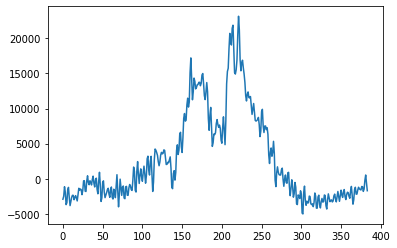

In [35]:
angle_deg = 10
template_2d_rot = ndimage.rotate(template_2d,angle_deg,reshape=False)
proj_1d = template_2d_rot.sum(0)
pd.Series(proj_1d).plot()

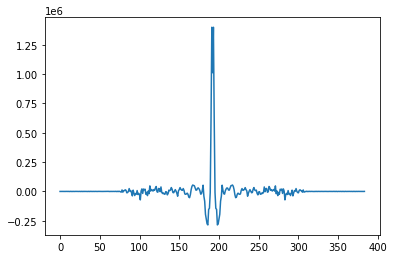

In [39]:
proj_1d_f = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(proj_1d)))
pd.Series(proj_1d_f.real).plot()

The high requency information has low amplitude, so there will likely be minimal edge effects from the rotating, so we don't need to apply any circular masking

In [40]:
proj_1d_f.shape, proj_1d_f[:2]

((384,), array([-31.92569733-3.63797881e-12j, 268.72722066-2.51910422e+02j]))

This FT of the 1D projections fill out a 1d line in the 2D Fourier fourier transform. We will fill it in, keeping track of how many counts we need to average (closer to the origin gets more counts)

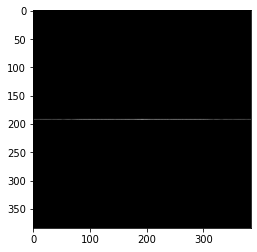

In [42]:
proj_2d_f = np.zeros_like(template_2d_f)
proj_2d_f[N//2,:] = proj_1d_f
doplt(logabs(proj_2d_f))


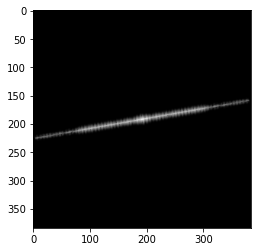

In [43]:
reconst_f = twod.do_complex_rotate(proj_2d_f,angle_deg)
doplt(logabs(reconst_f))


Some interpolations is automatically happening here

Now we can fill out all the angles

In [44]:
proj_2d_f = np.zeros_like(template_2d_f)
reconst_f = np.zeros_like(template_2d_f)
counts_2d = np.zeros(template_2d_f.shape)
ones_2d = np.zeros(template_2d_f.shape)
ones_2d[N//2,:] = np.ones(N)
for angle_deg in np.linspace(0,360,360):
  template_2d_rot = ndimage.rotate(template_2d,angle_deg,reshape=False)
  proj_1d = template_2d_rot.sum(0)
  counts_2d += ndimage.rotate(ones_2d,angle_deg,reshape=False)
  proj_1d_f = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(proj_1d)))
  proj_2d_f[N//2,:] = proj_1d_f # overwrites each time
  reconst_f += twod.do_complex_rotate(proj_2d_f,angle_deg)



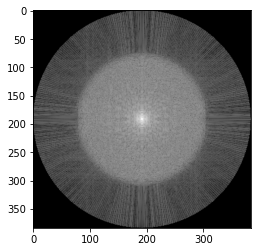

In [45]:
doplt(logabs(reconst_f))

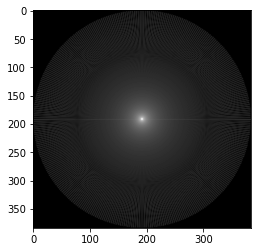

In [46]:
doplt(logabs(counts_2d))

In [47]:
obs_idx = counts_2d > .4
reconst_f_norm = reconst_f.copy()
reconst_f_norm[obs_idx] /= counts_2d[obs_idx]

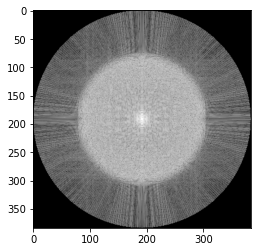

In [48]:
doplt(logabs(reconst_f_norm))

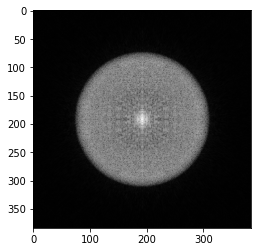

In [49]:
doplt(logabs(template_2d_f))

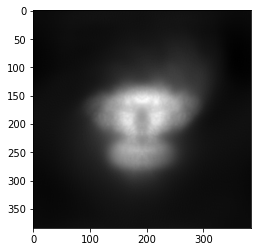

In [50]:
reconst_r = twod.do_ifft(reconst_f)
doplt(reconst_r)

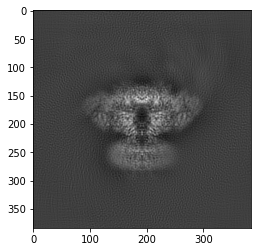

In [51]:
reconst_r_norm = twod.do_ifft(reconst_f_norm)
doplt(reconst_r_norm)

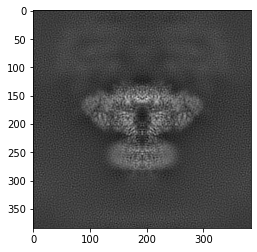

In [52]:
doplt(template_2d)

We see the importance of dividing out the counts for proper weighting in Fourier space. But rather than relying on how `ndimage.rotate` does the interpolations, we can keep track of the angles and use a more principled interpolation all at once (from angle space to cartesian space).

# Interpolation

* Taken from this post. I uses the image of a women "Lena", who has requested that her image stop being used, so I have used the 2D image of a protein. https://dsp.stackexchange.com/questions/3576/whats-wrong-with-this-code-for-tomographic-reconstruction-by-the-fourier-method

In [53]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import scipy.interpolate
import scipy.fftpack
import scipy.misc
import scipy.ndimage.interpolation

S=256 # Size of target, and resolution of Fourier space
N=259 # Number of sinogram exposures (odd number avoids redundant direct opposites)

V=100 # Range on fft plots



In [54]:
# Convenience function
def sqr(x): return x*x

# Return the angle of the i-th (of 0-to-N-1) sinogram exposure in radians.
def angle(i): return (math.pi*i)/N

In [57]:
# import cv2
# !wget https://www.ece.rice.edu/~wakin/images/lena512.bmp
# img = np.asarray(cv2.imread('lena512.bmp',cv2.IMREAD_GRAYSCALE))

img = template_2d

import PIL # https://github.com/tensorlayer/srgan/pull/179
resized = np.array(PIL.Image.fromarray(img).resize((S,S),  resample=PIL.Image.CUBIC))



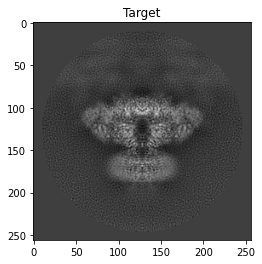

In [59]:
# Prepare a target image
x,y=np.meshgrid(np.arange(S)-S/2,np.arange(S)-S/2)
mask=(sqr(x)+sqr(y)<=sqr(S/2-10))
target=np.where(
    mask,
    resized,
    np.zeros((S,S))
    )/255.0

plt.figure()
plt.title("Target")
plt.imshow(target)
plt.gray()

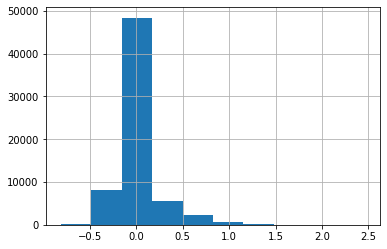

In [60]:
pd.Series(target.flatten()).hist()

In [61]:
# Project the sinogram (ie calculate Radon transform)
sinogram=np.array([
        np.sum(
            scipy.ndimage.interpolation.rotate(
                target,
                np.rad2deg(angle(i)), # NB rotate takes degrees argument
                order=3,
                reshape=False,
                mode='constant',
                cval=0.0
                )
            ,axis=0
            ) for i in range(N)
        ])

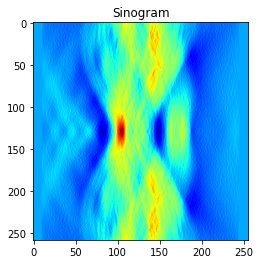

In [62]:
plt.figure()
plt.title("Sinogram")
plt.imshow(sinogram)
plt.jet()

Each line is a 1D projection. Ie the vertical axis is the angle of rotation, and the horizontal is the projection axis.

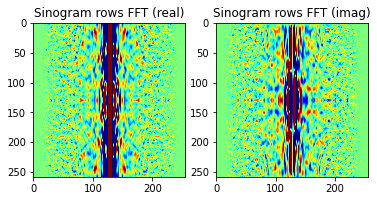

In [63]:
# Fourier transform the rows of the sinogram, move the DC component to the row's centre
sinogram_fft_rows=np.fft.fftshift(
    np.fft.fft(
        np.fft.ifftshift(
            sinogram,
            axes=1
            )
        ),
    axes=1
    )

plt.figure()
plt.subplot(121)
plt.title("Sinogram rows FFT (real)")
plt.imshow(np.real(sinogram_fft_rows),vmin=-V,vmax=V)
plt.subplot(122)
plt.title("Sinogram rows FFT (imag)")
plt.imshow(np.imag(sinogram_fft_rows),vmin=-V,vmax=V)

We can zoom in to the 2D FFT and see how regularly sampled it is.

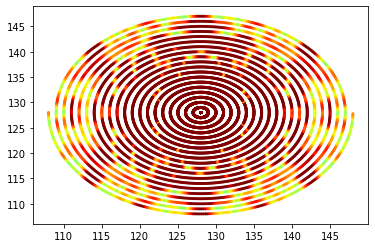

In [65]:
# Coordinates of sinogram FFT-ed rows' samples in 2D FFT space
sub_radius = 20
a=np.array([angle(i) for i in range(N)])
r=(np.arange(S)-S/2)[S//2-sub_radius:S//2+sub_radius]
r,a=np.meshgrid(r,a)
r=r.flatten()
a=a.flatten()
srcx=(S/2)+r*np.cos(a)
srcy=(S/2)+r*np.sin(a)

# Coordinates of regular grid in 2D FFT space
dstx,dsty=np.meshgrid(np.arange(S)[S//2-100:S//2+100],np.arange(S)[S//2-100:S//2+100])
dstx=dstx.flatten()
dsty=dsty.flatten()

#srcx.shape, sinogram_fft_rows[S//2-100:S//2+100].flatten().shape
plt.scatter(
    srcx,
    srcy,
    #c=np.absolute(sinogram_fft_rows[S//2-100:S//2+100].flatten()),
    c=np.absolute(sinogram_fft_rows[:,S//2-sub_radius:S//2+sub_radius].flatten()),

    marker='.',
    edgecolor='none',
    vmin=-V,
    vmax=V
    )

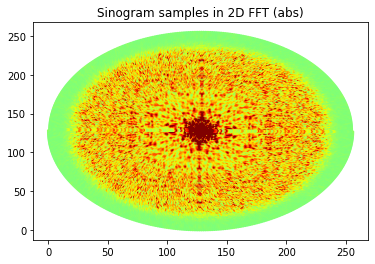

In [68]:
# Coordinates of sinogram FFT-ed rows' samples in 2D FFT space
a=np.array([angle(i) for i in range(N)])
r=np.arange(S)-S/2
r,a=np.meshgrid(r,a)
r=r.flatten()
a=a.flatten()
srcx=(S/2)+r*np.cos(a)
srcy=(S/2)+r*np.sin(a)

# Coordinates of regular grid in 2D FFT space
dstx,dsty=np.meshgrid(np.arange(S),np.arange(S))
dstx=dstx.flatten()
dsty=dsty.flatten()

plt.figure()
plt.title("Sinogram samples in 2D FFT (abs)")
plt.scatter(
    srcx,
    srcy,
    c=np.absolute(sinogram_fft_rows.flatten()),
    marker='.',
    edgecolor='none',
    vmin=-V,
    vmax=V
    )


The interpolation will fill in the missing values.

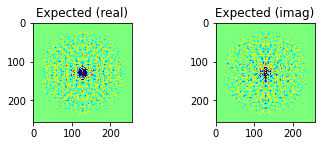

In [69]:
# Show 2D FFT of target, just for comparison
expected_fft2=np.fft.fftshift(
    np.fft.fft2(
        np.fft.ifftshift(
            target
            )
        )
    )

plt.subplot(223)
plt.title("Expected (real)")
plt.imshow(np.real(expected_fft2),vmin=-V,vmax=V)
plt.subplot(224)
plt.title("Expected (imag)")
plt.imshow(np.imag(expected_fft2),vmin=-V,vmax=V)

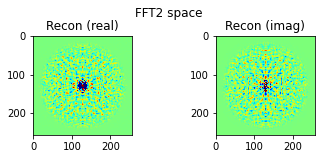

In [70]:
# Let the central slice theorem work its magic!
# Interpolate the 2D Fourier space grid from the transformed sinogram rows
fft2=scipy.interpolate.griddata(
    (srcy,srcx),
    sinogram_fft_rows.flatten(),
    (dsty,dstx),
    method='cubic',
    fill_value=0.0
    ).reshape((S,S))

plt.figure()
plt.suptitle("FFT2 space")
plt.subplot(221)
plt.title("Recon (real)")
plt.imshow(np.real(fft2),vmin=-V,vmax=V)
plt.subplot(222)
plt.title("Recon (imag)")
plt.imshow(np.imag(fft2),vmin=-V,vmax=V)

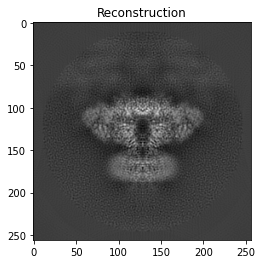

In [74]:
# Transform from 2D Fourier space back to a reconstruction of the target
recon=np.real(
    np.fft.fftshift(
        np.fft.ifft2(
            np.fft.ifftshift(fft2)
            )
        )
    )

plt.figure()
plt.title("Reconstruction")
plt.imshow(recon)
plt.gray()

# number of observations and interpolation method

Let's look at the quality of the reconstruction using various angular sampling (uniform, but large/fine steps between angles) and the interpolation method

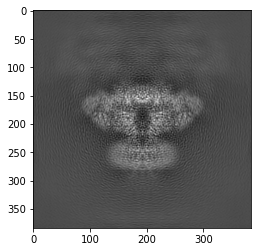

In [75]:
def fourier_slice_theorem(target,n_proj,interpolation_method):
  # https://dsp.stackexchange.com/questions/3576/whats-wrong-with-this-code-for-tomographic-reconstruction-by-the-fourier-method
  S = target.shape[0]
  #doplt(target)
  angles_deg = np.linspace(0,180,n_proj) 
  sinogram = np.zeros((angles_deg.shape[0],target.shape[0]))
  #sinogram_fft_rows = np.zeros(sinogram.shape,dtype=np.complex64)
  for idx,angle_deg in enumerate(angles_deg):
    rot = ndimage.rotate(target,angle_deg,reshape=False)
    proj = rot.sum(0)
    sinogram[idx,:] = proj
    #sinogram_fft_rows_loop[idx,:] = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(proj))) # need to do ifftshift inside first

  #doplt(sinogram,'jet')

  sinogram_fft_rows = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram,axes=1)),axes=1)
  #np.allclose(sinogram_fft_rows_loop,sinogram_fft_rows)

  # compare how different
  # pd.Series(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(proj))).real).plot()
  # pd.Series(np.fft.fftshift(np.fft.fft(proj)).real).plot()

  #doplt(sinogram_fft_rows.real,cmap='jet',vmin=-V,vmax=V)

  # interpolate
  # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
  a=angles_deg*np.pi/180 # radians
  r=np.arange(S)-S/2
  r,a=np.meshgrid(r,a)
  r=r.flatten()
  a=a.flatten()
  srcx=(S/2)+r*np.cos(a)
  srcy=(S/2)+r*np.sin(a)

  # Coordinates of regular grid in 2D FFT space
  dstx,dsty=np.meshgrid(np.arange(S),np.arange(S))
  dstx=dstx.flatten()
  dsty=dsty.flatten()

  fft2=scipy.interpolate.griddata(
      (srcy,srcx),
      sinogram_fft_rows.flatten(),
      (dsty,dstx),
      method=interpolation_method,
      fill_value=0.0
      ).reshape((S,S))

  # target agrees with reconstruction
  #doplt(fft2.real,cmap='jet',vmin=-V,vmax=V)
  #doplt(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(target))).real,cmap='jet',vmin=-V,vmax=V)

  # inverse FT
  recon = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fft2)))
  #recon = twod.do_ifft(fft2,only_real=True)
  return(recon)

#target = template_2d
N=100
recon = fourier_slice_theorem(template_2d,N,interpolation_method='cubic')
doplt(recon.real)

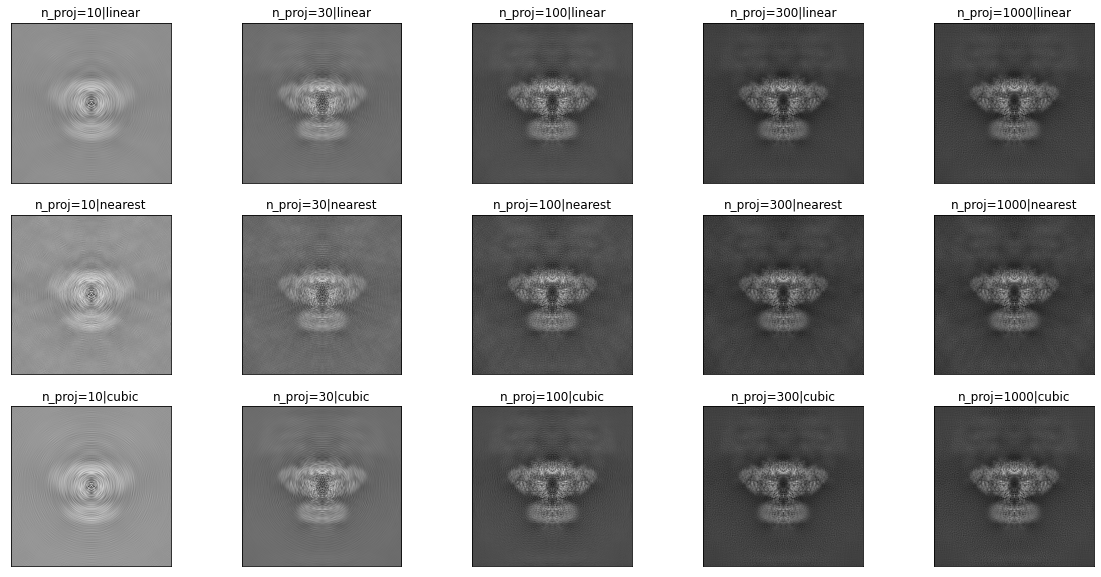

In [ ]:
n_projs = [10,30,100,300,1000]
interpolation_methods = ['linear','nearest','cubic']
fig,ax = plt.subplots(nrows=len(interpolation_methods),ncols=len(n_projs),figsize=(20,10))
for n_proj_idx,n_proj in enumerate(n_projs):
  for interpolation_method_idx, interpolation_method in enumerate(interpolation_methods):
    recon = fourier_slice_theorem(template_2d,n_proj,interpolation_method=interpolation_method)
    ax[interpolation_method_idx,n_proj_idx].imshow(recon.real,cmap='gray')
    ax[interpolation_method_idx,n_proj_idx].set_xticks([])
    ax[interpolation_method_idx,n_proj_idx].set_yticks([])
    ax[interpolation_method_idx,n_proj_idx].set_title('n_proj=%i|%s'%(n_proj,interpolation_method))

We see the `cubic` and `linear` interpolation do the best, especially surpressing noise. There are artefacts in `nearest`

Much of the computation can be refactored out, and only depends on the image size and number of samples.

Each of the observations is FT-ed, but this is done only once and can be done in bulk (not a loop) with `np.fft.fft`, taking care to shit and unshift wrt `axes=1`.

There is only one iFT at the end.

Doing this in 2D/3D would require rotating the object in 3D before projeting it to a 2D image.